In [1]:
# Library

import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.color import rgb2gray
from keras import Input
from keras.models import Model, load_model, save_model
from keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras import backend as K
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.applications.mobilenet_v2 import preprocess_input

In [2]:
# Image Size
im_width = 256
im_height = 256
# Loss Function
smooth=100

def dice_coef(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)
    And=K.sum(y_truef* y_predf)
    return((2* And + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth))

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def jac_distance(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)

    return - iou(y_true, y_pred)

In [3]:
# Load the saved model
loaded_model = load_model('unet_brain_mri_seg.hdf5', custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})

1/1 [==============================] - 1s 710ms/step


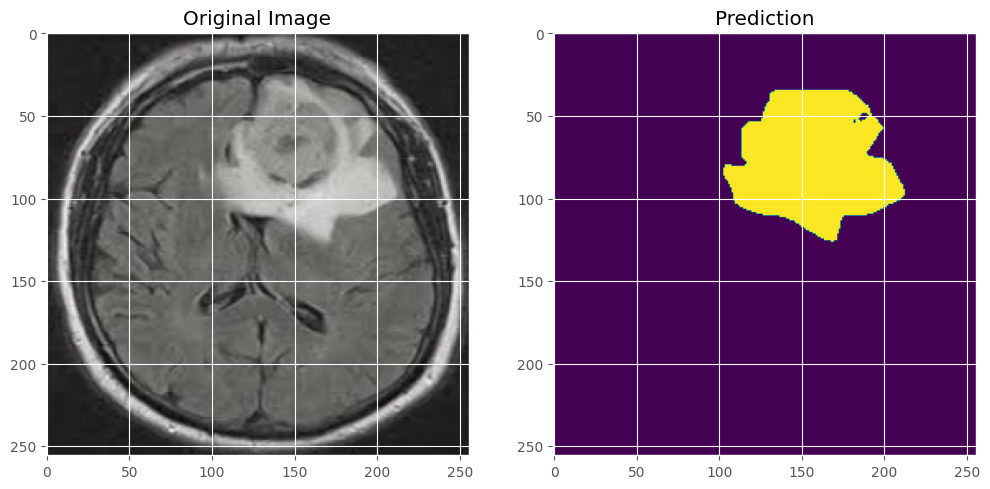

1/1 [==============================] - 0s 496ms/step


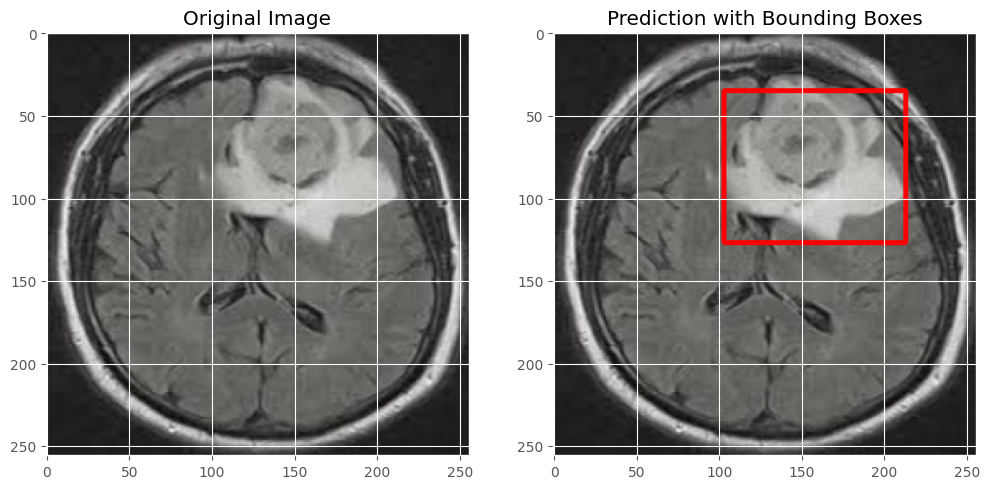

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img_path = './202.jpg'
img = cv2.imread(img_path)
img = cv2.resize(img,(im_height, im_width))
img = img / 255
img = img[np.newaxis, :, :, :]
pred=loaded_model.predict(img)
cv2.imwrite('segmentation.jpg', pred)

plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.imshow(np.squeeze(img))
plt.title('Original Image')
plt.subplot(1,2,2)
plt.imshow(np.squeeze(pred) > .5)
plt.title('Prediction')
plt.show()


img = cv2.imread(img_path)
img = cv2.resize(img, (im_width, im_height))
img = img / 255
img = img[np.newaxis, :, :, :]
pred = loaded_model.predict(img)

# Save the segmentation mask
cv2.imwrite('segmentation.jpg', (pred[0] * 255).astype(np.uint8))  # Ensure the values are in the correct range

# Find contours in the predicted segmentation mask
contours, _ = cv2.findContours((pred[0] > 0.5).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create a blank image with the same dimensions as the original image
output_image = np.copy(img[0] * 255).astype(np.uint8)

# Draw bounding boxes on the output image
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(output_image, (x, y), (x + w, y + h), (255, 0, 0), 2)

# Display the original image with bounding boxes
plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.imshow(np.squeeze(img))
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(output_image)
plt.title('Prediction with Bounding Boxes')
plt.show()


1/1 [==============================] - 1s 635ms/step


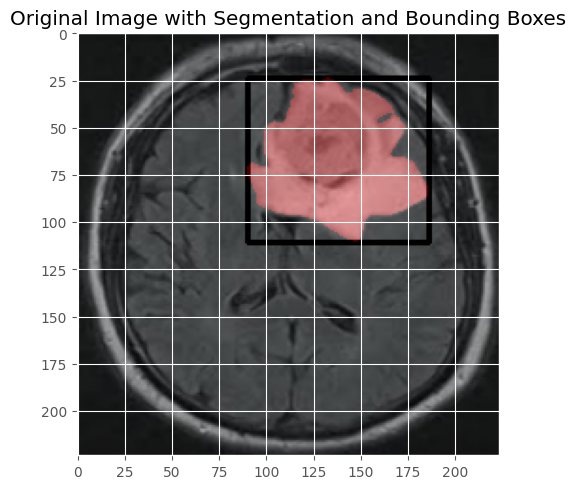

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess the image
im_height = 224  # Replace with your desired height
im_width = 224   # Replace with your desired width
img_path = './202.jpg'
img = cv2.imread(img_path)
img = cv2.resize(img, (im_width, im_height))
img = img / 255
img = img[np.newaxis, :, :, :]

# Make a prediction using your loaded model
pred = loaded_model.predict(img)
segmentation_mask = pred[0] > 0.5  # Assuming 0.5 is your threshold

# Convert the binary mask to grayscale
segmentation_gray = (segmentation_mask * 255).astype(np.uint8)[:,:,0]  # Remove the third channel

# Find contours in the segmentation mask
contours, _ = cv2.findContours(segmentation_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw bounding boxes on the original image
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(img[0], (x, y), (x + w, y + h), (0, 0, 255), 2)  # Red rectangle (BGR format)

# Convert the original image to uint8 format
original_img = (img[0] * 255).astype(np.uint8)

# Create a yellow mask from the segmentation grayscale
yellow_mask = np.zeros_like(original_img)
yellow_mask[:, :, 0] = 0  # Set blue channel to 0
yellow_mask[:, :, 1] = 0  # Set green channel to 255
yellow_mask[:, :, 2] = segmentation_gray  # Use the grayscale segmentation as the red channel

# Overlay the yellow mask on the original image
result_image = cv2.addWeighted(original_img, 0.7, yellow_mask, 0.3, 0, dtype=cv2.CV_8U)

# Save the result image
cv2.imwrite('segmentation.jpg', result_image)

# Display the result
plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))  # Convert to RGB for display
plt.title('Original Image with Segmentation and Bounding Boxes')
plt.show()
